In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

In [2]:
print(f"TensorFlow version = {tf.__version__}\n")

TensorFlow version = 2.0.0



In [3]:
SEED = 1337
np.random.seed(SEED)
tf.random.set_seed(SEED)

# the list of gestures that data is available for
GESTURES = [
    "left",
    "right",
]

In [17]:
SAMPLES_PER_GESTURE = 119

NUM_GESTURES = len(GESTURES)

# create a one-hot encoded matrix that is used in the output
ONE_HOT_ENCODED_GESTURES = np.eye(NUM_GESTURES)

inputs = []
outputs = []

# read each csv file and push an input and output
for gesture_index in range(NUM_GESTURES):
    gesture = GESTURES[gesture_index]
    print(f"Processing index {gesture_index} for gesture '{gesture}'.")

    output = ONE_HOT_ENCODED_GESTURES[gesture_index]

    df = pd.read_csv("~/Documents/Special_Projects/Arduino_Gesture/data/" + gesture + ".csv")

    # calculate the number of gesture recordings in the file
    num_recordings = int(df.shape[0] / SAMPLES_PER_GESTURE)

    print(f"\tThere are {num_recordings} recordings of the {gesture} gesture.")

    for i in range(num_recordings):
        tensor = []
        for j in range(SAMPLES_PER_GESTURE):
            index = i * SAMPLES_PER_GESTURE + j
            # normalize the input data, between 0 to 1:
            # - acceleration is between: -4 to +4
            # - gyroscope is between: -2000 to +2000
            tensor += [
              (df['aX'][index] + 4) / 8,
              (df['aY'][index] + 4) / 8,
              (df['aZ'][index] + 4) / 8,
              (df['gX'][index] + 2000) / 4000,
              (df['gY'][index] + 2000) / 4000,
              (df['gZ'][index] + 2000) / 4000
            ]

        inputs.append(tensor)
        outputs.append(output)

# convert the list to numpy array
inputs = np.array(inputs)
outputs = np.array(outputs)

print("Data set parsing and preparation complete.")

Processing index 0 for gesture 'left'.
	There are 10 recordings of the left gesture.
Processing index 1 for gesture 'right'.
	There are 11 recordings of the right gesture.
Data set parsing and preparation complete.


In [5]:
# Randomize the order of the inputs, so they can be evenly distributed for training, testing, and validation
# https://stackoverflow.com/a/37710486/2020087
num_inputs = len(inputs)
randomize = np.arange(num_inputs)
np.random.shuffle(randomize)

# Swap the consecutive indexes (0, 1, 2, etc) with the randomized indexes
inputs = inputs[randomize]
outputs = outputs[randomize]

# Split the recordings (group of samples) into three sets: training, testing and validation
TRAIN_SPLIT = int(0.6 * num_inputs)
TEST_SPLIT = int(0.2 * num_inputs + TRAIN_SPLIT)

inputs_train, inputs_test, inputs_validate = np.split(inputs, [TRAIN_SPLIT, TEST_SPLIT])
outputs_train, outputs_test, outputs_validate = np.split(outputs, [TRAIN_SPLIT, TEST_SPLIT])

print("Data set randomization and splitting complete.")

Data set randomization and splitting complete.


In [6]:
# build the model and train it
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(50, activation='relu')) # relu is used for performance
model.add(tf.keras.layers.Dense(15, activation='relu'))
model.add(tf.keras.layers.Dense(NUM_GESTURES, activation='softmax')) # softmax is used, because we only expect one gesture to occur per input
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(inputs_train, outputs_train, epochs=600, batch_size=1, validation_data=(inputs_validate, outputs_validate))

Train on 12 samples, validate on 5 samples
Epoch 1/600
12/12 [==============================] - 1s 43ms/sample - loss: 0.3750 - mae: 0.5592 - val_loss: 0.2493 - val_mae: 0.4921
Epoch 2/600
12/12 [==============================] - 0s 2ms/sample - loss: 0.2699 - mae: 0.5052 - val_loss: 0.2405 - val_mae: 0.4903
Epoch 3/600
12/12 [==============================] - 0s 2ms/sample - loss: 0.2463 - mae: 0.4873 - val_loss: 0.2564 - val_mae: 0.5064
Epoch 4/600
12/12 [==============================] - 0s 2ms/sample - loss: 0.2450 - mae: 0.4902 - val_loss: 0.2252 - val_mae: 0.4711
Epoch 5/600
12/12 [==============================] - 0s 2ms/sample - loss: 0.2192 - mae: 0.4639 - val_loss: 0.2757 - val_mae: 0.4973
Epoch 6/600
12/12 [==============================] - 0s 2ms/sample - loss: 0.2372 - mae: 0.4749 - val_loss: 0.2059 - val_mae: 0.4537
Epoch 7/600
12/12 [==============================] - 0s 2ms/sample - loss: 0.2088 - mae: 0.4491 - val_loss: 0.1934 - val_mae: 0.4397
Epoch 8/600
12/12 [======

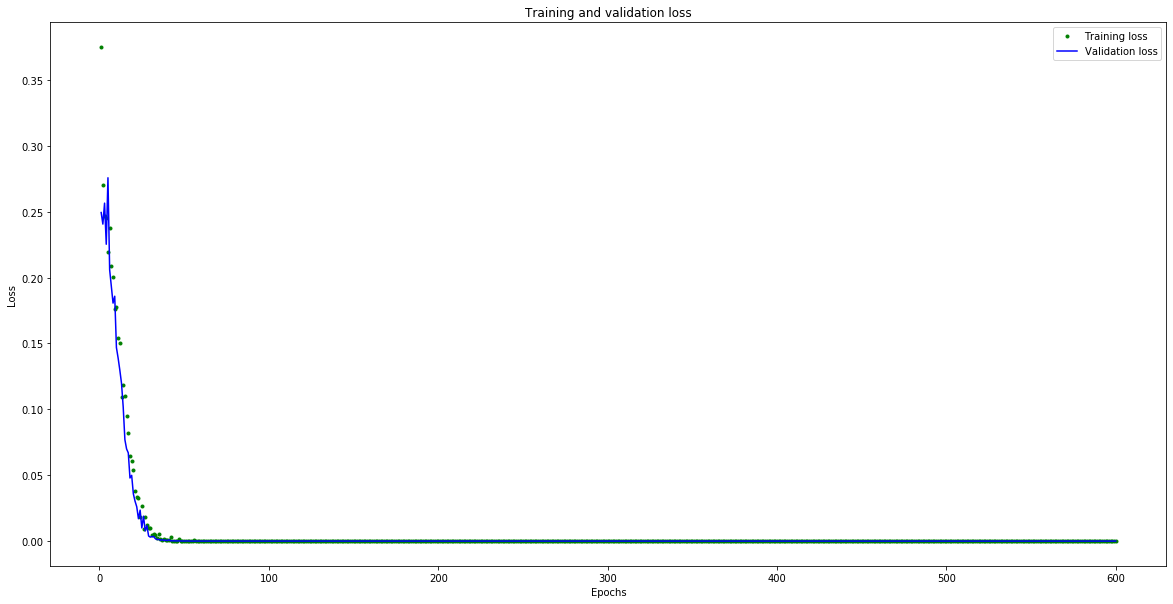

[20.0, 10.0]


In [7]:
# increase the size of the graphs. The default size is (6,4).
plt.rcParams["figure.figsize"] = (20,10)

# graph the loss, the model above is configure to use "mean squared error" as the loss function
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'g.', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

print(plt.rcParams["figure.figsize"])

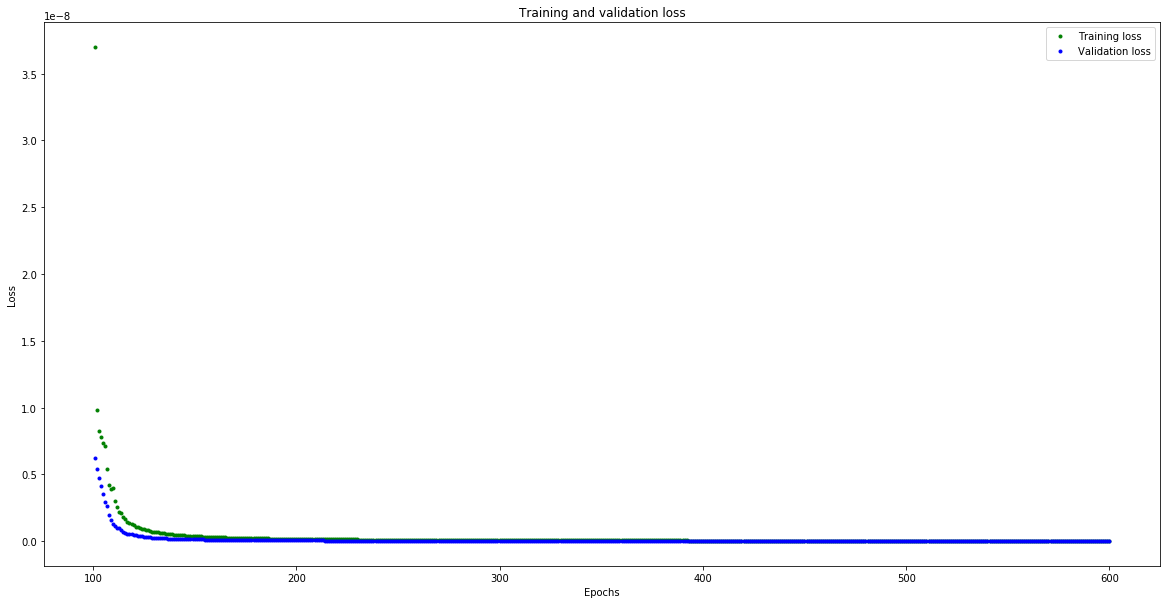

In [8]:
# graph the loss again skipping a bit of the start
SKIP = 100
plt.plot(epochs[SKIP:], loss[SKIP:], 'g.', label='Training loss')
plt.plot(epochs[SKIP:], val_loss[SKIP:], 'b.', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

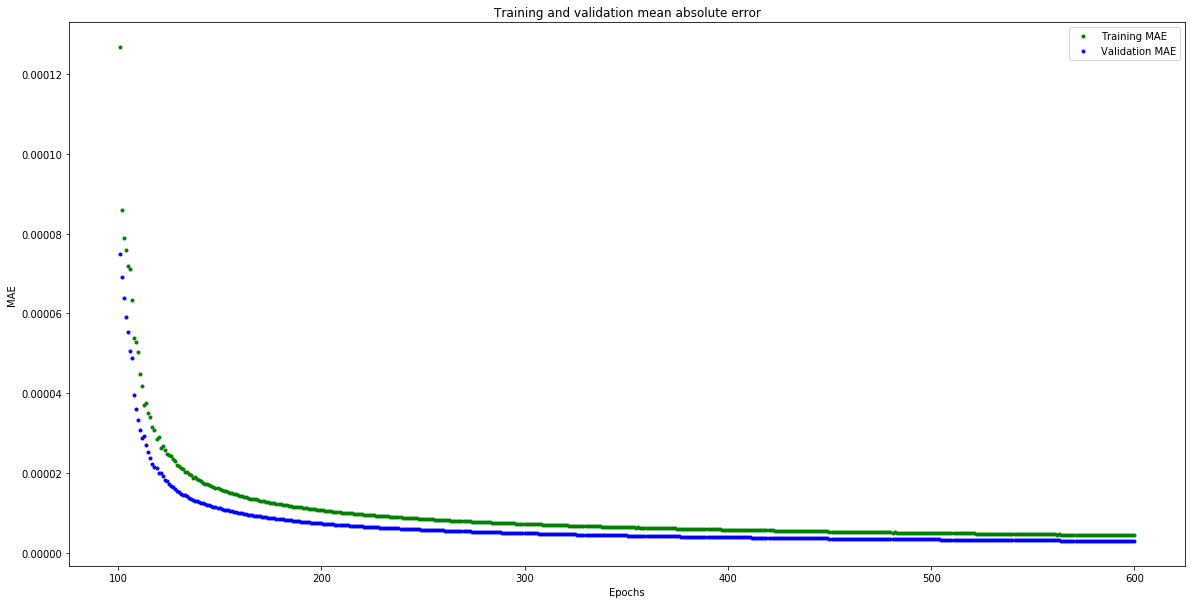

In [9]:
# graph of mean absolute error
mae = history.history['mae']
val_mae = history.history['val_mae']
plt.plot(epochs[SKIP:], mae[SKIP:], 'g.', label='Training MAE')
plt.plot(epochs[SKIP:], val_mae[SKIP:], 'b.', label='Validation MAE')
plt.title('Training and validation mean absolute error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

predictions =
 [[0.002 0.998]
 [0.    1.   ]
 [0.    1.   ]
 [1.    0.   ]]
actual =
 [[0. 1.]
 [0. 1.]
 [0. 1.]
 [1. 0.]]


/home/benski3030/anaconda3/envs/tf-gpu-latest/lib/python3.7/site-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  # This is added back by InteractiveShellApp.init_path()
/home/benski3030/anaconda3/envs/tf-gpu-latest/lib/python3.7/site-packages/ipykernel_launcher.py:12: MatplotlibDeprecationWarning: cycling among columns of inputs with non-matching shapes is deprecated.
  if sys.path[0] == '':


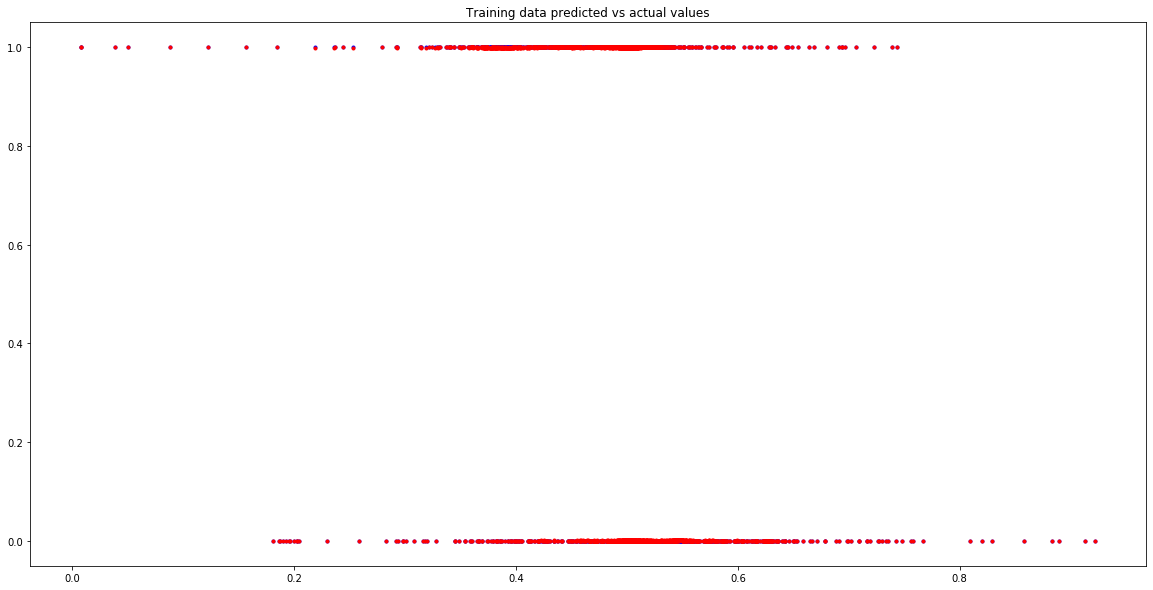

In [10]:
# use the model to predict the test inputs
predictions = model.predict(inputs_test)

# print the predictions and the expected ouputs
print("predictions =\n", np.round(predictions, decimals=3))
print("actual =\n", outputs_test)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(inputs_test, outputs_test, 'b.', label='Actual')
plt.plot(inputs_test, predictions, 'r.', label='Predicted')
plt.show()

In [26]:
import sys
import os
bin_path = os.path.dirname(sys.executable)

# this is a hack to get the environment vars to work
if 'PATH' in os.environ:
        os.environ['PATH'] += ':' + bin_path
else:
    os.environ['PATH'] = bin_path

# Convert the model to the TensorFlow Lite format without quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("gesture_model.tflite", "wb").write(tflite_model)
  
basic_model_size = os.path.getsize("gesture_model.tflite")
print("Model is %d bytes" % basic_model_size)

147764